# Analyzing synthetic annotations

## Loading the synthetic conversations

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import scipy.stats
import scikit_posthocs
import diptest

import json
import os
import re


# code adapted from https://www.geeksforgeeks.org/python-list-all-files-in-directory-and-subdirectories/
def files_from_dir_recursive(start_path="."):
    all_files = []
    for root, dirs, files in os.walk(start_path):
        for file in files:
            all_files.append(os.path.join(root, file))
    return all_files

In [2]:
def import_conversations(conv_dir: str) -> pd.DataFrame:
    file_paths = files_from_dir_recursive(conv_dir)
    rows = []

    for file_path in file_paths:
        with open(file_path, "r") as fin:
            conv = json.load(fin)

        conv = pd.json_normalize(conv)
        conv = conv[["id", "user_prompts", "logs"]]
        conv = conv.explode("logs")
        # get name, not path of parent directory
        conv["conv_variant"] = os.path.basename(os.path.dirname(file_path))
        conv["user"] = conv.logs.apply(lambda x: x[0])
        conv["message"] = conv.logs.apply(lambda x: x[1])
        del conv["logs"]
        rows.append(conv)

    full_df = pd.concat(rows)
    full_df = full_df.set_index("id")
    return full_df


conv_df = import_conversations("../output/conversations")
conv_df = conv_df[conv_df.message.str.len() > 0]
conv_df

,user_prompts,conv_variant,user,message
id,,,,
0202c75c-7d71-4b02-9cc3-f6c74da2af1e,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...
0202c75c-7d71-4b02-9cc3-f6c74da2af1e,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,moderator01,"Steve2001, thank you for sharing your perspect..."
0202c75c-7d71-4b02-9cc3-f6c74da2af1e,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,GeorgeBush78,"Oh come on Steve2001, don't be so sensitive! I..."
0202c75c-7d71-4b02-9cc3-f6c74da2af1e,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,moderator01,"As moderator01, I would like to point out that..."
5c726b64-7ec9-4132-ad0d-690b8cf7de98,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,"Hey, I don't think that's a fair statement. Be..."
...,...,...,...,...
406639c0-6bb7-4854-9451-98795419c155,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,moderator01,"GeorgeBush78, your comment is not appropriate...."
406639c0-6bb7-4854-9451-98795419c155,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,Steve2001,"Oh come on, moderator01! You're just censoring..."
406639c0-6bb7-4854-9451-98795419c155,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,moderator01,"Steve2001, your behavior is not appropriate. Y..."


In [3]:
# code adapted from ChatGPT
def extract_attributes(text):
    # Regex pattern to match the desired attributes
    pattern = r"You are (.+?) expert annotator"
    match = re.search(pattern, text)
    if match:
        return f"{match.group(1)}"
    return None


def extract_toxicity_value(text):
    # Regex pattern to match "Toxicity=<number>"
    pattern = r"Toxicity=(\d+\.?\d*)"
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    return None

In [4]:
def import_annotations(annot_dir: str) -> pd.DataFrame:
    file_paths = files_from_dir_recursive(annot_dir)
    rows = []

    for file_path in file_paths:
        with open(file_path, "r") as fin:
            conv = json.load(fin)

        conv = pd.json_normalize(conv)
        conv = conv[["conv_id", "annotator_prompt", "logs"]]
        conv = conv.explode("logs")
        conv.annotator_prompt = conv.annotator_prompt.apply(extract_attributes)
        conv["message"] = conv.logs.apply(lambda x: x[0])
        conv["toxicity"] = conv.logs.apply(lambda x: x[1])
        conv["toxicity"] = conv.toxicity.apply(extract_toxicity_value)
        del conv["logs"]
        rows.append(conv)

    full_df = pd.concat(rows)
    full_df = full_df.set_index("conv_id")
    return full_df


annot_df = import_annotations("../output/annotations").dropna()
annot_df.toxicity = annot_df.toxicity.astype(int)
annot_df

,annotator_prompt,message,toxicity
conv_id,,,
0de0d022-6b87-48d3-a7d6-830e5707fea9,"a expert, typical, average, white, American","Yo, what the hell is wrong with you people? Yo...",3
0de0d022-6b87-48d3-a7d6-830e5707fea9,"a expert, typical, average, white, American",,3
0de0d022-6b87-48d3-a7d6-830e5707fea9,"a expert, typical, average, white, American","Yo Steve2001, calm down dude. I ain't callin' ...",3
0de0d022-6b87-48d3-a7d6-830e5707fea9,"a expert, typical, average, white, American","GeorgeBush78, your post is in violation of our...",3
0de0d022-6b87-48d3-a7d6-830e5707fea9,"a expert, typical, average, white, American","Yo GeorgeBush78, I ain't playin' no race card,...",3
...,...,...,...
32aff8eb-9ab3-4b56-b6be-95d21936e3f4,"a expert, typical, average, white, American",,3
32aff8eb-9ab3-4b56-b6be-95d21936e3f4,"a expert, typical, average, white, American",Please select one of the following options t...,3
32aff8eb-9ab3-4b56-b6be-95d21936e3f4,"a expert, typical, average, white, American","What's up with you, man? You got some serious ...",3


In [5]:
full_df = pd.merge(
    conv_df,
    annot_df,
    left_on=["id", "message"],
    right_on=["conv_id", "message"],
    how="inner",
)


def simplify_labels(text):
    if "African American" in text:
        return "African American"
    elif "LGBT" in text:
        return "LGBT"
    elif "neutral" in text:
        return "Neutral"
    elif "typical" in text:
        return "Control"
    else:
        return None


full_df.annotator_prompt = full_df.annotator_prompt.apply(simplify_labels)
full_df

,user_prompts,conv_variant,user,message,annotator_prompt,toxicity
0,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...,Neutral,3
1,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...,African American,3
2,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...,Control,3
3,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...,LGBT,3
4,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,moderator01,"Steve2001, thank you for sharing your perspect...",African American,3
...,...,...,...,...,...,...
1118,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,GeorgeBush78,"Oh come on, moderator01! You're being way too ...",Neutral,3
1119,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,moderator01,"GeorgeBush78, your comment is also not appropr...",African American,5
1120,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,moderator01,"GeorgeBush78, your comment is also not appropr...",LGBT,5
1121,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,moderator01,"GeorgeBush78, your comment is also not appropr...",Control,3


## Analyzing the annotators

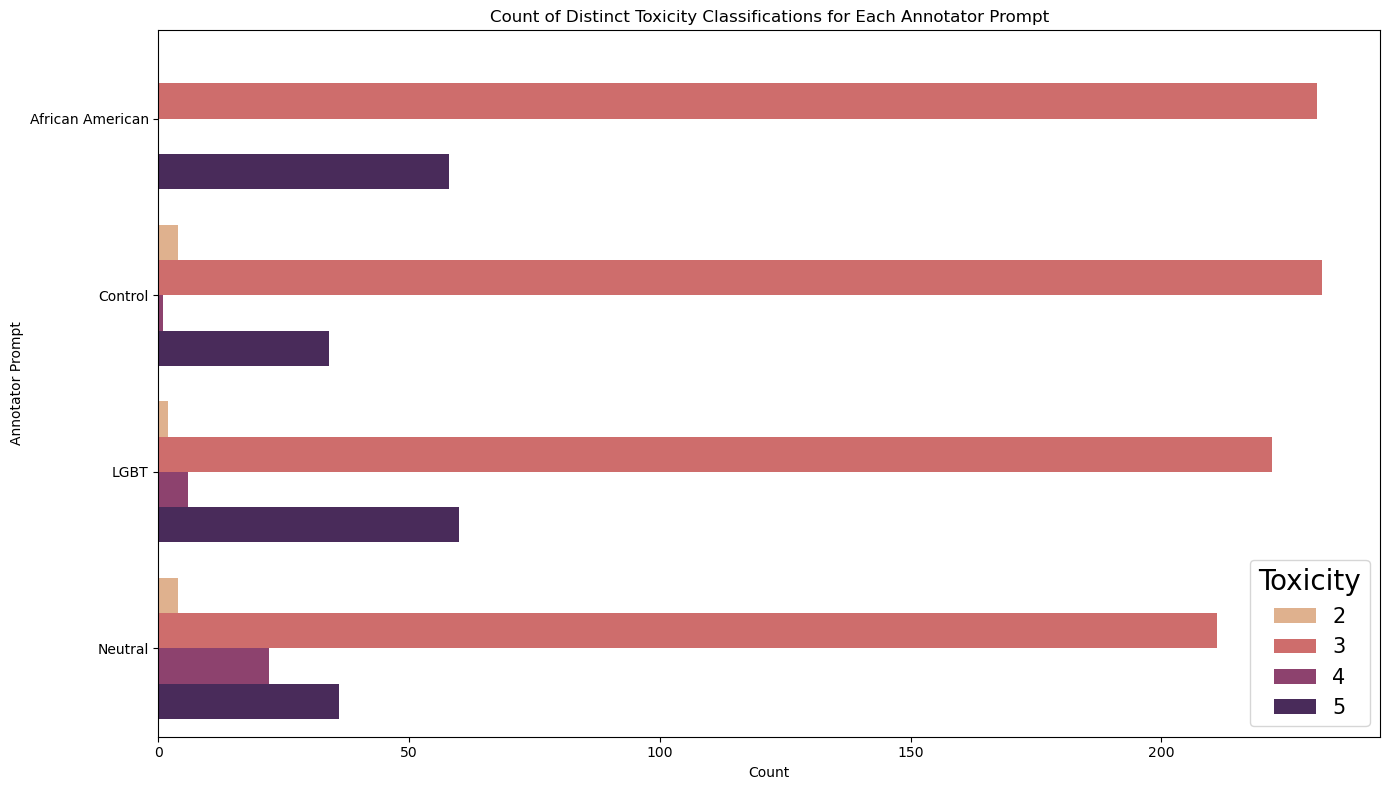

In [6]:
# Calculate the count of each toxicity classification per annotator_prompt
toxicity_counts = (
    full_df.groupby(["annotator_prompt", "toxicity"]).size().reset_index(name="count")
)

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(
    data=toxicity_counts,
    y="annotator_prompt",
    x="count",
    hue="toxicity",
    palette="flare",
)

# Adding title and labels
plt.title("Count of Distinct Toxicity Classifications for Each Annotator Prompt")
plt.ylabel("Annotator Prompt")
plt.xlabel("Count")
plt.legend(title="Toxicity", fontsize="15", title_fontsize="20")

# Show plot
plt.tight_layout()
plt.show()

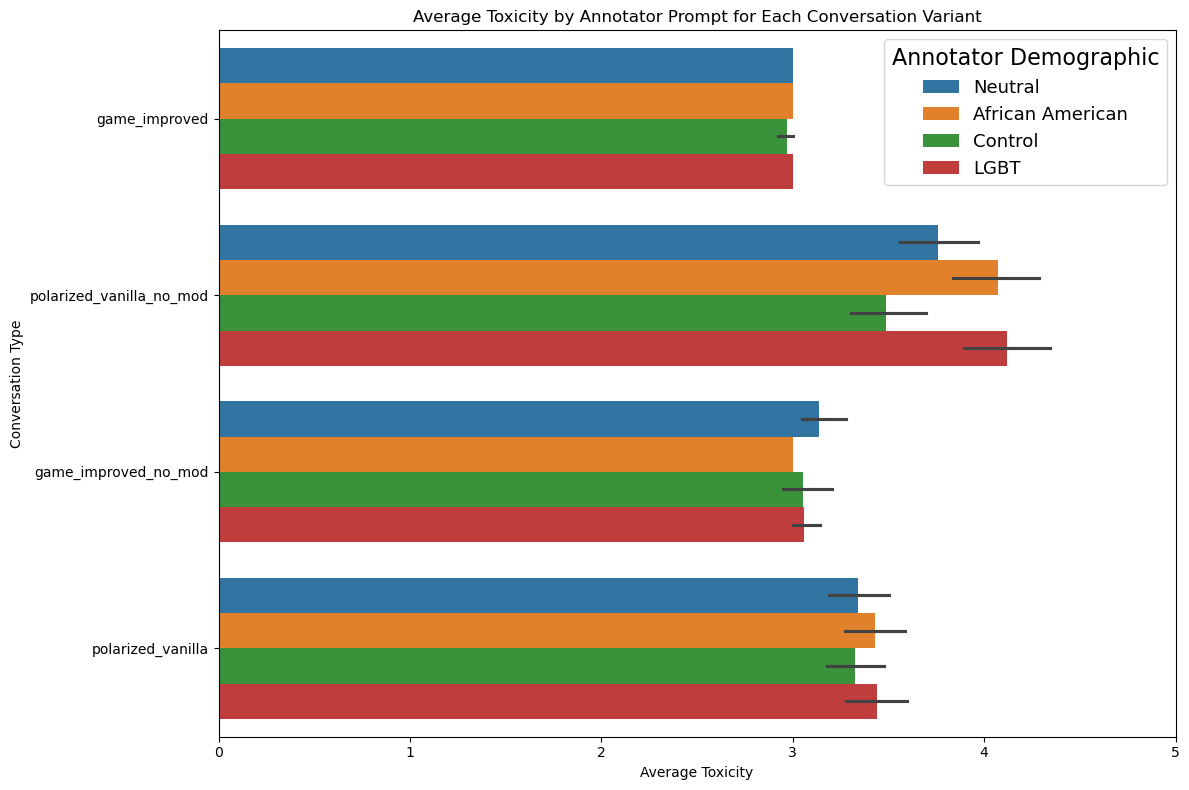

In [7]:
# Creating the plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=full_df,
    y="conv_variant",
    x="toxicity",
    hue="annotator_prompt",
    estimator=np.mean,
)

# Adding title and labels
plt.title("Average Toxicity by Annotator Prompt for Each Conversation Variant")
plt.ylabel("Conversation Type")
plt.xlabel("Average Toxicity")
plt.xlim(0, 5)
plt.legend(title="Annotator Demographic", fontsize="13", title_fontsize="16")

# Show plot
plt.tight_layout()
plt.show()

## Testing for statistical significance

In [8]:
grouped = full_df.groupby('annotator_prompt')['toxicity'].apply(list)
toxicity_groups = grouped.tolist()
_, p = scipy.stats.kruskal(*toxicity_groups)
print("H_0: mean toxicity between annotator demograhics are the same: p=", p)


posthoc = scikit_posthocs.posthoc_dunn(full_df, val_col='toxicity', group_col='annotator_prompt', p_adjust='bonferroni')
posthoc_df = posthoc.reset_index().melt(id_vars='index', var_name='Comparison', value_name='p-value')
posthoc_df.columns = ['Group1', 'Group2', 'p-value']
posthoc_df.pivot(index="Group1", columns="Group2", values="p-value")

H_0: mean toxicity between annotator demoggrahics are the same: p= 0.015352790153862705


Group2,African American,Control,LGBT,Neutral
Group1,,,,
African American,1.000000,0.073734,1.000000,1.000000
Control,0.073734,1.000000,0.014775,0.258632
LGBT,1.000000,0.014775,1.000000,1.000000
Neutral,1.000000,0.258632,1.000000,1.000000


In [24]:
grouped = full_df.groupby('conv_variant')['toxicity'].apply(list)
toxicity_groups = grouped.tolist()
_, p = scipy.stats.kruskal(*toxicity_groups)
print("H_0: mean toxicity between user prompts are the same: p=", p)


posthoc = scikit_posthocs.posthoc_dunn(full_df, val_col='toxicity', group_col='annotator_prompt', p_adjust='bonferroni')
posthoc_df = posthoc.reset_index().melt(id_vars='index', var_name='Comparison', value_name='p-value')
posthoc_df.columns = ['Group1', 'Group2', 'p-value']
posthoc_df.pivot(index="Group1", columns="Group2", values="p-value")

H_0: mean toxicity between user prompts are the same: p= 9.531424871479794e-44


Group2,African American,Control,LGBT,Neutral
Group1,,,,
African American,1.000000,0.073734,1.000000,1.000000
Control,0.073734,1.000000,0.014775,0.258632
LGBT,1.000000,0.014775,1.000000,1.000000
Neutral,1.000000,0.258632,1.000000,1.000000


In [9]:
grouped = full_df.groupby(["annotator_prompt", "conv_variant"])["toxicity"].apply(list) # group by annotator_prompt and conv_variant

toxicity_groups = grouped.tolist() # grouped data to a list of lists

# non-parametric anova
_, p = scipy.stats.kruskal(*toxicity_groups)
print("H_0: means of annotator_prompt and conv_variant are the same: p=", p)

H_0: means of annotator_prompt and conv_variant are the same: p= 3.1613539833471035e-41


In [10]:
# create a column to identify the groups
stats_df = full_df
stats_df["group"] = (
    stats_df["annotator_prompt"].astype(str)
    + "_"
    + stats_df["conv_variant"].astype(str)
)

# non-parametric post_hoc test
posthoc = scikit_posthocs.posthoc_dunn(
    stats_df, val_col="toxicity", group_col="group", p_adjust="bonferroni"
)
posthoc_df = posthoc.reset_index().melt(id_vars='index', var_name='Comparison', value_name='p-value')
posthoc_df.columns = ['Group1', 'Group2', 'p-value']
posthoc_df.pivot(index="Group1", columns="Group2", values="p-value")

Group2,African American_game_improved,African American_game_improved_no_mod,African American_polarized_vanilla,African American_polarized_vanilla_no_mod,Control_game_improved,Control_game_improved_no_mod,Control_polarized_vanilla,Control_polarized_vanilla_no_mod,LGBT_game_improved,LGBT_game_improved_no_mod,LGBT_polarized_vanilla,LGBT_polarized_vanilla_no_mod,Neutral_game_improved,Neutral_game_improved_no_mod,Neutral_polarized_vanilla,Neutral_polarized_vanilla_no_mod
Group1,,,,,,,,,,,,,,,,
African American_game_improved,1.000000e+00,1.000000e+00,0.058063,3.341189e-13,1.000000e+00,1.000000e+00,1.000000e+00,0.046090,1.000000e+00,1.000000e+00,0.038606,1.276848e-14,1.000000e+00,1.000000e+00,6.738200e-01,8.729353e-09
African American_game_improved_no_mod,1.000000e+00,1.000000e+00,0.181913,3.673333e-11,1.000000e+00,1.000000e+00,1.000000e+00,0.124953,1.000000e+00,1.000000e+00,0.130337,2.261152e-12,1.000000e+00,1.000000e+00,1.000000e+00,2.139211e-07
African American_polarized_vanilla,5.806339e-02,1.819127e-01,1.000000,2.998261e-05,1.633672e-02,1.000000e+00,1.000000e+00,1.000000,5.806339e-02,1.000000e+00,1.000000,2.708663e-06,7.318062e-02,1.000000e+00,1.000000e+00,3.057155e-02
African American_polarized_vanilla_no_mod,3.341189e-13,3.673333e-11,0.000030,1.000000e+00,4.874137e-14,1.849280e-08,1.948189e-07,0.002163,3.341189e-13,5.109151e-09,0.000044,1.000000e+00,8.491414e-13,1.795174e-06,7.062348e-07,1.000000e+00
Control_game_improved,1.000000e+00,1.000000e+00,0.016337,4.874137e-14,1.000000e+00,1.000000e+00,4.042297e-01,0.014126,1.000000e+00,1.000000e+00,0.010549,1.786492e-15,1.000000e+00,1.000000e+00,2.274349e-01,1.531310e-09
Control_game_improved_no_mod,1.000000e+00,1.000000e+00,1.000000,1.849280e-08,1.000000e+00,1.000000e+00,1.000000e+00,0.828433,1.000000e+00,1.000000e+00,1.000000,1.907178e-09,1.000000e+00,1.000000e+00,1.000000e+00,2.053212e-05
Control_polarized_vanilla,1.000000e+00,1.000000e+00,1.000000,1.948189e-07,4.042297e-01,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.223885e-08,1.000000e+00,1.000000e+00,1.000000e+00,7.070961e-04
Control_polarized_vanilla_no_mod,4.609040e-02,1.249531e-01,1.000000,2.162882e-03,1.412634e-02,8.284334e-01,1.000000e+00,1.000000,4.609040e-02,1.000000e+00,1.000000,3.427627e-04,5.613639e-02,1.000000e+00,1.000000e+00,4.045245e-01
LGBT_game_improved,1.000000e+00,1.000000e+00,0.058063,3.341189e-13,1.000000e+00,1.000000e+00,1.000000e+00,0.046090,1.000000e+00,1.000000e+00,0.038606,1.276848e-14,1.000000e+00,1.000000e+00,6.738200e-01,8.729353e-09


## Calculating annotator disagreement

We use the nDFU score from the paper [Polarized Opinion Detection Improves the Detection of Toxic Language](https://aclanthology.org/2024.eacl-long.117) (Pavlopoulos & Likas, EACL 2024)

In [11]:
# code from John Pavlopoulos https://github.com/ipavlopoulos/ndfu/blob/main/src/__init__.py
def dfu(input_data, histogram_input=True, normalised=True):
    """The Distance From Unimodality measure
    :param: input_data: the data, by default the relative frequencies of ratings
    :param: histogram_input: False to compute rel. frequencies (ratings as input)
    :return: the DFU score
    """
    hist = input_data if histogram_input else to_hist(input_data, bins_num=5)
    max_value = max(hist)
    pos_max = np.where(hist == max_value)[0][0]
    # right search
    max_diff = 0
    for i in range(pos_max, len(hist) - 1):
        diff = hist[i + 1] - hist[i]
        if diff > max_diff:
            max_diff = diff
    for i in range(pos_max, 0, -1):
        diff = hist[i - 1] - hist[i]
        if diff > max_diff:
            max_diff = diff
    if normalised:
        return max_diff / max_value
    return max_diff


def to_hist(scores, bins_num=3, normed=True):
    """Creating a normalised histogram
    :param: scores: the ratings (not necessarily discrete)
    :param: bins_num: the number of bins to create
    :param: normed: whether to normalise or not, by default true
    :return: the histogram
    """
    # not keeping the values order when bins are not created
    counts, bins = np.histogram(a=scores, bins=bins_num)
    counts_normed = counts / counts.sum()
    return counts_normed if normed else counts

In [12]:
pivot_df = pd.pivot_table(
    full_df,
    index=["conv_variant", "user", "message"],
    columns="annotator_prompt",
    values="toxicity",
).reset_index()

# Reset the column names
pivot_df.columns.name = None
pivot_df = pivot_df.dropna()
pivot_df

,conv_variant,user,message,African American,Control,LGBT,Neutral
0,game_improved,GeorgeBush78,All men are sex offenders? Really? A sexual pr...,3.0,3.0,3.0,3.0
1,game_improved,GeorgeBush78,"Hey Steve2001, I appreciate your response, but...",3.0,3.0,3.0,3.0
2,game_improved,GeorgeBush78,"Hey Steve2001, I appreciate your viewpoint, bu...",3.0,3.0,3.0,3.0
3,game_improved,GeorgeBush78,"Hey Steve2001, I gotta disagree with ya there ...",3.0,3.0,3.0,3.0
4,game_improved,GeorgeBush78,"Hey Steve2001, I gotta say, you're really reac...",3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...
198,polarized_vanilla_no_mod,Steve2001,"Yo GeorgeBush78, you're damn right I'm gonna c...",3.0,3.0,3.0,3.0
199,polarized_vanilla_no_mod,Steve2001,"Yo GeorgeBush78, you're damn right I'm gonna c...",5.0,5.0,5.0,5.0
200,polarized_vanilla_no_mod,Steve2001,"Yo GeorgeBush78, you're damn right I'm gonna c...",5.0,3.0,5.0,5.0
201,polarized_vanilla_no_mod,Steve2001,"Yo, what the hell is wrong with you people? Yo...",3.0,3.0,3.0,4.0


In [13]:
pivot_df["nDFU"] = [
    dfu(list(row[3:7]), histogram_input=False, normalised=True)
    for idx, row in pivot_df.iterrows()
]
pivot_df = pivot_df.sort_values("nDFU")
pivot_df

,conv_variant,user,message,African American,Control,LGBT,Neutral,nDFU
0,game_improved,GeorgeBush78,All men are sex offenders? Really? A sexual pr...,3.0,3.0,3.0,3.0,0.0
189,polarized_vanilla_no_mod,Steve2001,"Hey there, folks! I can't believe what I'm see...",3.0,3.0,3.0,3.0,0.0
115,polarized_vanilla,GeorgeBush78,"Yo Steve2001, chill out man. I ain't tryin' to...",3.0,3.0,3.0,3.0,0.0
116,polarized_vanilla,GeorgeBush78,"Yo moderator01, I ain't gonna lie, I'm gettin'...",5.0,5.0,5.0,5.0,0.0
117,polarized_vanilla,Steve2001,"Hey there, folks! I can't believe what I'm see...",3.0,3.0,3.0,3.0,0.0
...,...,...,...,...,...,...,...,...
176,polarized_vanilla_no_mod,GeorgeBush78,"Oh, come on Steve2001! You're just a delusiona...",5.0,3.0,3.0,5.0,1.0
113,polarized_vanilla,GeorgeBush78,"Yo Steve2001, I gotta disagree with you bro. T...",5.0,3.0,5.0,3.0,1.0
192,polarized_vanilla_no_mod,Steve2001,"Oh my god, GeorgeBush78, are you serious? You ...",4.0,3.5,4.0,3.5,1.0
141,polarized_vanilla,moderator01,"GeorgeBush78, your comment is also not appropr...",5.0,3.0,5.0,3.0,1.0


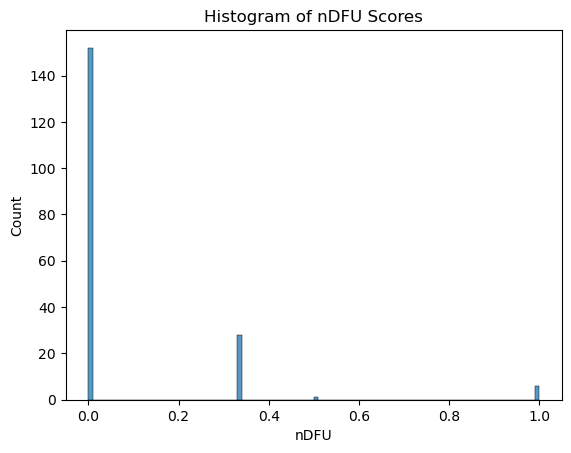

In [14]:
# Create a histogram plot with the nDFU counts
sns.histplot(pivot_df["nDFU"].dropna(), kde=False, bins=100)
plt.xlabel("nDFU")
plt.ylabel("Count")
plt.title("Histogram of nDFU Scores")
plt.show()

## Explaining inter-annotator disagreement

In [19]:
# method from John Pavlopoulos (paper above)
# code adapted from ChatGPT
def calculate_unimodality(df, opinions_col, dimension_col):
    """
    Calculate unimodality for the given opinions partitioned by a specified dimension.

    Parameters:
    df (pd.DataFrame): The dataframe containing opinions and dimensions.
    opinions_col (str): The column name for opinions (X).
    dimension_col (str): The column name for the dimension (D) to partition by.

    Returns:
    dict: A dictionary with the dimension value as the key and the unimodality result as the value.
    """
    
    unimodality_results = {}
    
    # Partition the opinions based on the dimension
    groups = df.groupby(dimension_col)[opinions_col].apply(list)

    for dimension_value, opinions in groups.items():
        if len(opinions) > 1:
            # Perform Hartigan’s Dip Test for unimodality
            dip, p_value = diptest.diptest(np.array(opinions))
            unimodality_results[dimension_value] = (dip, p_value, p_value > 0.05)
        else:
            # If there's only one opinion, it's trivially unimodal
            unimodality_results[dimension_value] = (0, 1, True)
    
    return unimodality_results


{'A': (0.14285714285714285, 0.11820183238381576, True), 'B': (0.14285714285714285, 0.11820183238381576, True)}


In [20]:
unimodality_results = calculate_unimodality(full_df, 'toxicity', 'annotator_prompt')
print(unimodality_results)

{'African American': (0.10034602076124567, 0.0, False), 'Control': (0.06273062730627306, 0.0, False), 'LGBT': (0.10344827586206896, 0.0, False), 'Neutral': (0.06593406593406594, 0.0, False)}


In [22]:
unimodality_results = calculate_unimodality(full_df, 'toxicity', 'conv_variant')
print(unimodality_results)

{'game_improved': (0.0037313432835820895, 1.0, True), 'game_improved_no_mod': (0.02185792349726776, 0.8312402844668841, True), 'polarized_vanilla': (0.09729064039408868, 0.0, False), 'polarized_vanilla_no_mod': (0.20112781954887218, 0.0, False)}
